## Описание задачи

Технологии искусственного интеллекта трансформируют сферу управления персоналом, позволяя решать практические HR-задачи. Уже
сейчас умные алгоритмы могут подобрать кадры, спланировать размер фонда заработной платы, выбрать образовательные курсы, оценить
мотивацию, эффективность труда и даже спрогнозировать карьерное развитие специалиста.
Аналитика по определению карьерной траектории строится, в том числе, на основе данных по использованию различных корпоративных
информационных систем (система мониторинга рабочего времени, сервисы видеоконференцсвязи, IP-телефонии, СЭД, СКУД, электронная почта). Таким образом, для некоторых профессий, связанных с активным использованием электронных устройств (программист, бухгалтер, маркетолог и т.д.), можно выделить цифровой профиль успешных специалистов, выполняющих задачи своевременно и качественно и получающих новые должности.

Имея на руках данные о повышении работников и информацию об ихактивности, истории посещения офиса и успеваемости по задачам, можно получить прогнозную модель, которая будет предсказывать изменение должности сотрудников автоматически.

На основе метаданных работников разработайте прогнозную модель,которая будет предсказывать, какой тип повышения получитсотрудник в будущем.

В качестве метрики выступает **Recall** по столбцу **type**

## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv(r'C:\project_jupyter\saha\train.csv')
df_test = pd.read_csv(r'C:\project_jupyter\saha\test.csv')

df_calls = pd.read_csv(r'C:\project_jupyter\saha\Calls.csv')
df_connection_time = pd.read_csv(r'C:\project_jupyter\saha\ConnectionTime.csv')
df_ed = pd.read_csv(r'C:\project_jupyter\saha\Education.csv')
df_skud = pd.read_csv(r'C:\project_jupyter\saha\SKUD.csv')
df_tasks = pd.read_csv(r'C:\project_jupyter\saha\Tasks.csv')


## Рассмотрим датасет по ближе

* Calls.csv — файл, содержащий данные о звонках
* ConnectionTime.csv — определение опозданий по данным
* Education.csv — файл, содержащий данные об образовании сотрудников
* SKUD.csv — файл, содержащий данные прихода/ухода сотрудников на рабочее место 
* Tasks.csv — файл, содержащий данные о исполнение задач
* TimenNetwork.csv — интервалы времени в сети в системе учета рабочего времени сотрудника за компьютером
* WorkingDay.csv — файл, содержащий интервалы времени активности система учета рабочего времени сотрудника за компьютером
* train.csv — файл, содержащий данные сотрудников с типом повышения для тренировки
* test.csv — пример файла для отправки, содержит id работников, для которых требуется предсказать тип повышения.

In [3]:
df_test.head()

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0


In [4]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


Выделим самый главный признак - количество звонков

In [5]:
df_calls_pt=df_calls[['NumberOfCalls','id']].groupby('id').sum()
df_calls_pt= df_calls_pt.reset_index()
df_calls_pt

,id,NumberOfCalls
0,ОРГ1-00004,5655
1,ОРГ1-00005,3501
2,ОРГ1-00028,2083
3,ОРГ1-00030,3003
4,ОРГ1-00044,4032
...,...,...
1066,ОРГ2-05629,8
1067,ОРГ2-05862,5
1068,ОРГ2-05932,23
1069,ОРГ2-06006,1


In [6]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


Выделим самый главный признак - опаздания сотрудников

In [7]:
df_connection_time_pt=df_connection_time[['id','Признак опоздания']].groupby('id').count()
df_connection_time_pt = df_connection_time_pt.reset_index()
df_connection_time_pt

,id,Признак опоздания
0,ОРГ1-00004,275
1,ОРГ1-00028,35
2,ОРГ1-00030,57
3,ОРГ1-00044,33
4,ОРГ1-00046,178
...,...,...
1583,ОРГ2-08179,0
1584,ОРГ2-08181,3
1585,ОРГ2-08203,7
1586,ОРГ2-08204,1


In [8]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


Выделим самый главный признак - вид образования и закодируем его

In [9]:
df_ed["Вид образования"] = df_ed["Вид образования"].astype('category')
df_ed["Вид образования"] = df_ed["Вид образования"].cat.codes
df_ed_pt = df_ed[['Вид образования','id']].drop_duplicates()
df_ed_pt

,Вид образования,id
0,2,ОРГ1-00131
1,15,ОРГ1-03220
2,1,ОРГ1-03008
3,2,ОРГ1-00922
4,1,ОРГ1-00922
...,...,...
5604,6,ОРГ2-08601
5605,6,ОРГ2-08622
5606,15,ОРГ2-04773
5607,3,ОРГ2-05048


In [10]:
df_skud.head()

,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
0,"2021-03-01 00:00:00,000","1899-12-30 08:11:00,000","1899-12-30 17:32:00,000","9,35","8,35",Будни,ОРГ1-00791
1,"2021-03-01 00:00:00,000","1899-12-30 08:25:00,000","1899-12-30 17:32:00,000","9,1166666666666671","8,1166666666666671",Будни,ОРГ1-01826
2,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-00713
3,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-02127
4,"2021-03-01 00:00:00,000","1899-12-30 08:19:00,000","1899-12-30 17:32:00,000","9,2166666666666668","8,2166666666666668",Будни,ОРГ1-01739


Выделим самый главный признак - длительность рабочего дня для сотрдуника(без учета обеда)

In [11]:

df_skud['Длительность раб.дня без обеда'] = df_skud['Длительность раб.дня без обеда'].apply(lambda x: float(x.split()[0].replace(',','.')))
df_skud_pt=df_skud[['Длительность раб.дня без обеда','id']].groupby('id').sum()


In [12]:
df_skud_pt=df_skud_pt.reset_index()
df_skud_pt

,id,Длительность раб.дня без обеда
0,ОРГ1-00002,596.116667
1,ОРГ1-00004,269.316667
2,ОРГ1-00005,292.633333
3,ОРГ1-00008,70.000000
4,ОРГ1-00010,252.366667
...,...,...
860,ОРГ1-06173,199.300000
861,ОРГ1-06213,24.066667
862,ОРГ1-06217,178.800000
863,ОРГ1-06290,5.533333


In [13]:
df_tasks.head()

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588


ПРосчитаем сколько в среднем дней просрочки имеет сотрудник

In [14]:
df_tasks_pt_1 = df_tasks[['Просрочено, дней','ID задачи','id']].groupby('id').sum()
df_tasks_pt_1 = df_tasks_pt_1.reset_index()
display(df_tasks_pt_1)
df_tasks_pt_2 = df_tasks[['ID задачи','id']].groupby('id').count()
df_tasks_pt_2 = df_tasks_pt_2.reset_index()
display(df_tasks_pt_2)


,id,"Просрочено, дней"
0,ОРГ1-00004,8857
1,ОРГ1-00005,1481
2,ОРГ1-00028,51
3,ОРГ1-00030,17
4,ОРГ1-00044,1748
...,...,...
1267,ОРГ2-06006,308
1268,ОРГ2-06061,79
1269,ОРГ2-06084,140
1270,ОРГ2-06115,416


,id,ID задачи
0,ОРГ1-00004,1146
1,ОРГ1-00005,2219
2,ОРГ1-00028,244
3,ОРГ1-00030,36
4,ОРГ1-00044,314
...,...,...
1267,ОРГ2-06006,395
1268,ОРГ2-06061,108
1269,ОРГ2-06084,28
1270,ОРГ2-06115,6


In [15]:
df_tasks_pt_3 = pd.merge(df_tasks_pt_2, df_tasks_pt_1, on="id", how='left')
df_tasks_pt_3['avg']= df_tasks_pt_3['Просрочено, дней']/ df_tasks_pt_3['ID задачи']
df_tasks_pt_3=df_tasks_pt_3[['id','avg']]
df_tasks_pt_3

,id,avg
0,ОРГ1-00004,7.728621
1,ОРГ1-00005,0.667418
2,ОРГ1-00028,0.209016
3,ОРГ1-00030,0.472222
4,ОРГ1-00044,5.566879
...,...,...
1267,ОРГ2-06006,0.779747
1268,ОРГ2-06061,0.731481
1269,ОРГ2-06084,5.000000
1270,ОРГ2-06115,69.333333


In [16]:
df_train.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [17]:
df_test.head(3)

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0


**Вывод:**

Осмотрели основные данные о сотрудников из разных датасетов. Отобрав основные признаки, которые должны влиять на дальнейшие карьерные перспективы и траекторию сотрудников. К ним относятся: 

* Количество опозданий
* Количество звонков
* Тип образования
* Длительность рабочего дня (без учета обеда)
* Среднее количество дней просрочки задач

В дальнейшим объединим эти признаки в один датасет

### Видоизмение данных

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      550 non-null    object
 1   type    550 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


Обьединим наборы с данными

In [19]:
df_train = pd.merge(df_train, df_connection_time_pt, on="id", how='left').drop_duplicates(subset="id")
df_train = pd.merge(df_train, df_calls_pt, on="id", how='left').drop_duplicates(subset="id")
df_train = pd.merge(df_train, df_ed_pt, on="id", how='left').drop_duplicates(subset="id")
df_train = pd.merge(df_train, df_skud_pt, on="id", how='left').drop_duplicates(subset="id")
df_train = pd.merge(df_train, df_tasks_pt_3, on="id", how='left').drop_duplicates(subset="id")
df_train=df_train.fillna(0)


In [20]:
df_train

,id,type,Признак опоздания,NumberOfCalls,Вид образования,Длительность раб.дня без обеда,avg
0,ОРГ1-02050,2,5.0,546.0,7.0,259.683333,0.000000
1,ОРГ1-02783,2,7.0,1902.0,1.0,0.000000,2.813725
2,ОРГ2-06173,0,22.0,0.0,1.0,0.000000,0.000000
3,ОРГ2-05359,2,6.0,0.0,15.0,0.000000,0.000000
4,ОРГ1-00803,2,35.0,7.0,1.0,0.000000,12.350000
...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,0.0,0.0,0.0,0.000000,26.302158
546,ОРГ1-02383,2,54.0,4570.0,1.0,49.283333,116.180952
547,ОРГ1-02862,2,0.0,0.0,0.0,0.000000,0.000000
548,ОРГ1-00471,2,12.0,3917.0,-1.0,0.000000,1.606061


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              550 non-null    object 
 1   type                            550 non-null    int64  
 2   Признак опоздания               550 non-null    float64
 3   NumberOfCalls                   550 non-null    float64
 4   Вид образования                 550 non-null    float64
 5   Длительность раб.дня без обеда  550 non-null    float64
 6   avg                             550 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 34.4+ KB


Данные не потеряли, призаки добавили, оценим корреляцию

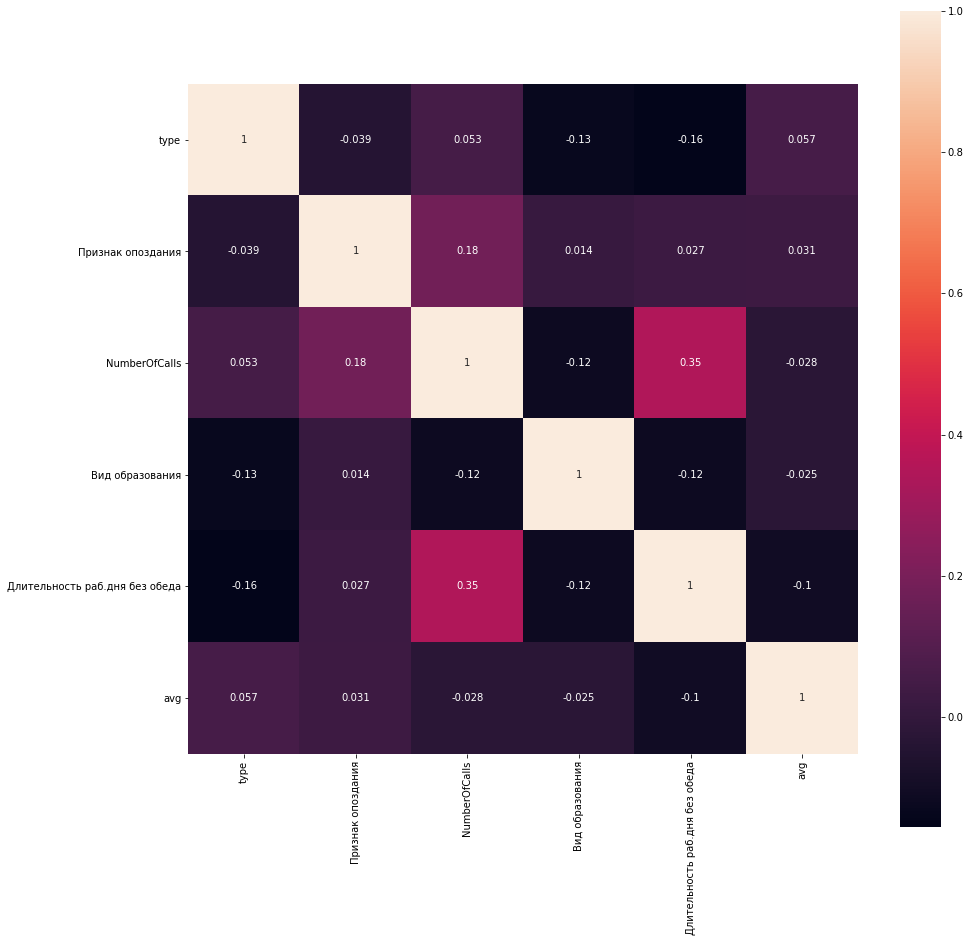

In [22]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

Приступим к обучению моделей и прогнозированию карьерного трека сотрудника

## Выделим выборки

Выделим выборки и разобьем их на обучающие и тестовую выборку. 

In [23]:
x = df_train.drop(["id", "type"], axis = 1)
y = df_train[["type"]]

In [24]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Признак опоздания               550 non-null    float64
 1   NumberOfCalls                   550 non-null    float64
 2   Вид образования                 550 non-null    float64
 3   Длительность раб.дня без обеда  550 non-null    float64
 4   avg                             550 non-null    float64
dtypes: float64(5)
memory usage: 25.8 KB


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Обучение модели

Обучим три модели:
1 - Случайный лес со случайным подбором гипперпарамметров

2 - Логистическую регрессию

3 - Случайный лес с подбором гипперпараметров в цикле с учетом максимизации **RECALL**

Во всем моделях будем использовать балансировку классов-так как итоговая метрика несбалансирована по классам

In [26]:
rfc_1 = RandomForestClassifier()

In [27]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc_1, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(x_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 500,
 'min_samples_split': 12,
 'min_samples_leaf': 18,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

In [28]:
rfc_1 = RandomForestClassifier(n_estimators =  500, min_samples_split = 39, min_samples_leaf = 18,max_features ='sqrt' ,max_depth = 11,bootstrap = False,class_weight='balanced')

In [29]:
rfc_1.fit(x_train, y_train)
predicted_rfc_1 = rfc_1.predict(x_test)
display("Recall:", recall_score(y_test, predicted_rfc_1,average='macro', zero_division = 0))

'Recall:'

0.3308010335917313

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(x_train,y_train)
predicted_valid = model.predict(x_test)
display("Recall:", recall_score(y_test, predicted_valid,average='macro', zero_division = 0))

'Recall:'

0.3360335917312662

In [31]:

best_model = None
best_recall = 0
best_est = 0
best_depth = 0



for est in range(1, 60):
    for depth in range (1, 60):
        model = RandomForestClassifier(random_state=12345, n_estimators= est,max_depth=depth,class_weight='balanced',n_jobs=-1)
        model.fit(x_train,y_train)
        predicted_valid = model.predict(x_test)
        recall = recall_score(y_test, predicted_valid,average='macro', zero_division = 0) 
        if recall > best_recall:
            best_model = model
            best_recall = recall
            best_est = est 
            best_depth = depth
                

                

                
display("Recall :", best_recall)
display("Наилучшее количество деревьев в модели :", best_est)
display("Наилучшая максимальной глубина:", best_depth)



display(best_model)

'Recall :'

0.43290697674418605

'Наилучшее количество деревьев в модели :'

23

'Наилучшая максимальной глубина:'

1

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=23,
                       n_jobs=-1, random_state=12345)

In [32]:
best_model = RandomForestClassifier(random_state=12345, n_estimators= 23,max_depth=1,class_weight='balanced',n_jobs=-1)

In [33]:
best_model.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=23,
                       n_jobs=-1, random_state=12345)

**Вывод**

Мы обучили три модели, лучшую точность показала модель случайного леса гипперпараметры которой подбирались в цикле с учетом макмимизации **RECALL**. 

Ее параметры и будем использовать для прогнозирования на тестовой выборке

## Оценка точности

In [34]:
pred = best_model.predict(x_test)

In [35]:
y_test.head(3)

,type
195,2
79,2
480,0


In [36]:


print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.43290697674418605


## Формирование признаков для модели

Сформируем призаки для тестового датасета и сформируем предсказание по лучшей обученной модели

In [37]:
df_test.head()

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0


In [38]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      262 non-null    object
 1   type    262 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [39]:
df_test = pd.merge(df_test, df_connection_time_pt, on="id", how='left').drop_duplicates(subset="id")
df_test = pd.merge(df_test, df_calls_pt, on="id", how='left').drop_duplicates(subset="id")
df_test = pd.merge(df_test, df_ed_pt, on="id", how='left').drop_duplicates(subset="id")
df_test = pd.merge(df_test, df_skud_pt, on="id", how='left').drop_duplicates(subset="id")
df_test = pd.merge(df_test, df_tasks_pt_3, on="id", how='left').drop_duplicates(subset="id")
df_test=df_test.fillna(0)

In [40]:
df_test.head()

,id,type,Признак опоздания,NumberOfCalls,Вид образования,Длительность раб.дня без обеда,avg
0,ОРГ1-02649,0,0.0,4.0,0.0,316.183333,0.000000
1,ОРГ2-05929,0,19.0,0.0,2.0,0.000000,0.000000
2,ОРГ2-05859,0,104.0,0.0,14.0,0.000000,193.700000
3,ОРГ1-00279,0,15.0,8163.0,1.0,153.516667,0.382979
4,ОРГ2-01613,0,17.0,0.0,3.0,0.000000,27.222222


In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              262 non-null    object 
 1   type                            262 non-null    int64  
 2   Признак опоздания               262 non-null    float64
 3   NumberOfCalls                   262 non-null    float64
 4   Вид образования                 262 non-null    float64
 5   Длительность раб.дня без обеда  262 non-null    float64
 6   avg                             262 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 16.4+ KB


In [42]:
X_1 = df_test.drop(["id", "type"], axis = 1)
y_1 = df_test[["id", "type"]]

In [43]:
df_test_pred = best_model.predict(X_1)

In [44]:
y_1["type"] = df_test_pred
y_1.head()

,id,type
0,ОРГ1-02649,3
1,ОРГ2-05929,1
2,ОРГ2-05859,1
3,ОРГ1-00279,3
4,ОРГ2-01613,1


In [45]:
y_1.to_csv(r'C:\project_jupyter\saha\y_1.csv', index=False)

## Общий вывод

Для обучения модели по предсказанию карьерного пути сотрудника было сделано следующее:

Осмотрели основные данные о сотрудников из разных датасетов. Отобрав основные признаки, которые должны влиять на дальнейшие карьерные перспективы и траекторию сотрудников. К ним относятся: 

* Количество опозданий
* Количество звонков
* Тип образования
* Длительность рабочего дня (без учета обеда)
* Среднее количество дней просрочки задач

В дальнейшим объединив эти признаки в один датасет.

Обучили три модели:
* 1 - Случайный лес со случайным подбором гипперпарамметров

* 2 - Логистическую регрессию

* 3 - Случайный лес с подбором гипперпараметров в цикле с учетом максимизации **RECALL**

Лучшией результат показата моедль случайного леса, подобранная в цикле.